This code was used to generate data for centernet but the output csv was useful to determine where our initial labeling algorithm placed the intersections. 

In [ ]:
!gdown 1se3BrRr2M82zN7sf-52OM_BYyt4gZVpK
!unzip P03_6000_train.zip -d P03_6000_train
!cp /content/P03_6000_train/* /content/ -r
!rm /content/P03_6000_train/P03_6000_train -r

Streaming output truncated to the last 5000 lines.
  inflating: P03_6000_train/P03_6000_train/train_orto/orto_477000_6489000.gif  
  inflating: P03_6000_train/P03_6000_train/train_orto/orto_477000_6490000.gif  
  inflating: P03_6000_train/P03_6000_train/train_orto/orto_477000_6492000.gif  
  inflating: P03_6000_train/P03_6000_train/train_orto/orto_477000_6493000.gif  
  inflating: P03_6000_train/P03_6000_train/train_orto/orto_477000_6495000.gif  
  inflating: P03_6000_train/P03_6000_train/train_orto/orto_477000_6496000.gif  
  inflating: P03_6000_train/P03_6000_train/train_orto/orto_477000_6497000.gif  
  inflating: P03_6000_train/P03_6000_train/train_orto/orto_477000_6498000.gif  
 extracting: P03_6000_train/P03_6000_train/train_orto/orto_477000_6500000.gif  
  inflating: P03_6000_train/P03_6000_train/train_orto/orto_477000_6507000.gif  
  inflating: P03_6000_train/P03_6000_train/train_orto/orto_477000_6508000.gif  
  inflating: P03_6000_train/P03_6000_train/train_orto/orto_477000_650

In [ ]:
from google.colab import files

files.upload()

Saving train_centernet.csv to train_centernet.csv


{'train_centernet.csv': b'image_id,xmin,ymin,width,height,centerx,centery\n372000_6472000,907.0,643.0,30,30,922,658\n372000_6472000,929.0,651.0,30,30,944,666\n372000_6472000,970.0,748.0,29.0,30,985,763\n372000_6472000,959.0,933.0,30,30,974,948\n373000_6463000,310.0,943.0,30,30,325,958\n373000_6463000,478.0,551.0,30,30,493,566\n373000_6463000,352.0,842.0,30,30,367,857\n373000_6463000,664.0,146.0,30,30,679,161\n373000_6463000,336.0,765.0,30,30,351,780\n373000_6463000,383.0,601.0,30,30,398,616\n373000_6463000,701.0,127.0,30,30,716,142\n373000_6463000,295.0,960.0,30,30,310,975\n373000_6463000,314.0,966.0,30,30,329,981\n375000_6459000,561.0,603.0,30,30,576,618\n375000_6459000,542.0,629.0,30,30,557,644\n375000_6459000,598.0,505.0,30,30,613,520\n375000_6459000,918.0,523.0,30,30,933,538\n375000_6459000,338.0,901.0,30,30,353,916\n375000_6459000,346.0,870.0,30,30,361,885\n375000_6459000,397.0,889.0,30,30,412,904\n375000_6459000,509.0,755.0,30,30,524,770\n375000_6459000,365.0,938.0,30,30,380,953\

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm,trange
from sklearn.model_selection import train_test_split
import sklearn.metrics
import imageio

In [ ]:
df = pd.read_csv('/content/train_cleaned.csv')
df.columns = ['image_id']

In [ ]:
df['image_id'] = df['image_id'].str.replace('.gif', '')

<ipython-input-12-87273b52bf7b>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['image_id'] = df['image_id'].str.replace('.gif', '')


In [ ]:
df

,image_id
0,461000_6510000
1,565000_6543000
2,436000_6498000
3,643000_6396000
4,466000_6513000
...,...
5343,643000_6559000
5344,664000_6516000
5345,524000_6514000
5346,623000_6518000


In [ ]:
black_df = pd.read_csv('/content/black_images.csv', header=None)
black_df.columns = ['image_id']

In [ ]:
final_df = pd.DataFrame(columns=['image_id', 'xmin', 'ymin', 'width', 'height', 'centerx', 'centery'])

In [ ]:
INTERSECTION_SIZE = 30
UPPER_LIMIT = 999
LOWER_LIMIT = 0

def create_bbox(center_x, center_y, width, height):
  xmin = center_x - width / 2
  ymin = center_y - height / 2

  if xmin < LOWER_LIMIT:
    width = width - np.absolute(xmin)
    xmin = LOWER_LIMIT

  elif xmin + width > UPPER_LIMIT:
    width = width - (xmin + width - UPPER_LIMIT)

  if ymin < LOWER_LIMIT:
    height = height - np.absolute(ymin)
    ymin = LOWER_LIMIT

  elif ymin + height > UPPER_LIMIT:
    height = height - (ymin + height - UPPER_LIMIT)

  return (xmin, ymin, width, height)

In [ ]:
with open("ristmikud.csv") as f:
  for n, line in enumerate(f):
    line = line.strip().split(',')
    image = line.pop(0)
    if any(df['image_id'] == image):
      for i, intersection in enumerate(line):
        inter_coords = intersection.strip().split('-')
        inter_coords = [int(x) for x in inter_coords]
        (xmin, ymin, width, height) = create_bbox(inter_coords[0], inter_coords[1], INTERSECTION_SIZE, INTERSECTION_SIZE)

        new_row_df = pd.DataFrame([{'image_id': image, 'xmin': xmin, 'ymin': ymin, 'width': width, 'height': height, 'centerx': inter_coords[0], 'centery':inter_coords[1]}])
        final_df = pd.concat([final_df, new_row_df], ignore_index=True)

In [ ]:
final_df

,image_id,xmin,ymin,width,height,centerx,centery
0,372000_6472000,907.0,643.0,30,30,922,658
1,372000_6472000,929.0,651.0,30,30,944,666
2,372000_6472000,970.0,748.0,29.0,30,985,763
3,372000_6472000,959.0,933.0,30,30,974,948
4,373000_6463000,310.0,943.0,30,30,325,958
...,...,...,...,...,...,...,...
41539,725000_6577000,404.0,542.0,30,30,419,557
41540,725000_6577000,428.0,572.0,30,30,443,587
41541,725000_6577000,547.0,689.0,30,30,562,704
41542,725000_6577000,696.0,867.0,30,30,711,882


In [ ]:
unique_count = final_df['image_id'].nunique()
unique_count

3940

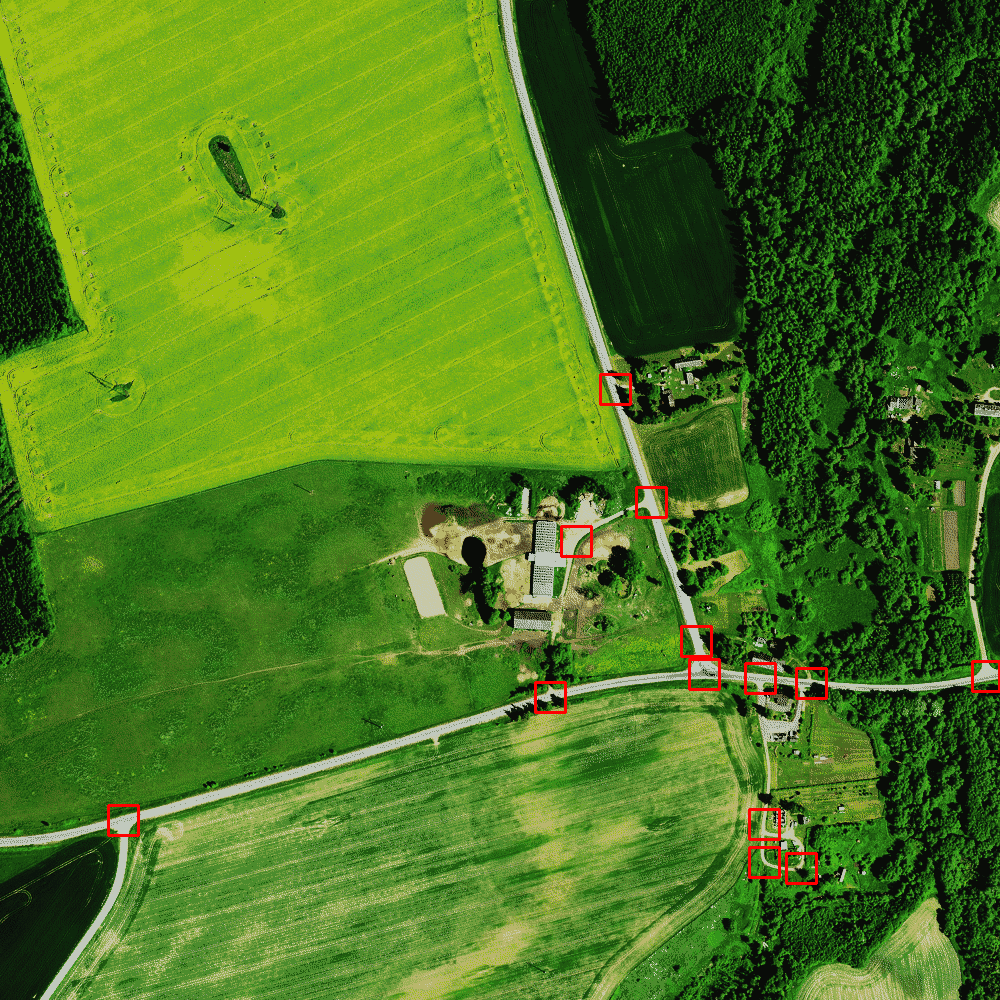

In [ ]:
from google.colab.patches import cv2_imshow

pic = "670000_6462000"

test_gif = imageio.mimread(f"P03_6000_train/train_orto/orto_{pic}.gif")
test_gif = np.array(cv2.cvtColor(test_gif[0], cv2.COLOR_RGB2BGR))

img = test_gif.copy()

filtered_rows = final_df[final_df['image_id'] == pic]

for index, row in filtered_rows.iterrows():

    xmin = int(row['xmin'])
    ymin = int(row['ymin'])
    width = int(row['width'])
    height = int(row['height'])

    cv2.rectangle(img, (xmin, UPPER_LIMIT - ymin - height), (xmin + width, UPPER_LIMIT - ymin), (0, 0, 255), 2)

cv2_imshow(img)

In [ ]:
filtered_rows

,image_id,xmin,ymin,width,height,centerx,centery
35324,670000_6462000,108.0,164.0,30,30,123,179
35325,670000_6462000,796.0,301.0,30,30,811,316
35326,670000_6462000,561.0,443.0,30,30,576,458
35327,670000_6462000,535.0,287.0,30,30,550,302
35328,670000_6462000,600.0,595.0,30,30,615,610
35329,670000_6462000,636.0,482.0,30,30,651,497
35330,670000_6462000,681.0,343.0,30,30,696,358
35331,670000_6462000,749.0,160.0,30,30,764,175
35332,670000_6462000,786.0,116.0,30,30,801,131
35333,670000_6462000,749.0,122.0,30,30,764,137


In [ ]:
final_df.to_csv('train_centernet.csv', index=False)

In [ ]:
del final_df